# "Hot Zone" Analysis
## - Find the number of "hot zones" in each grouping of participants
## - A hot zone is a sentence with over 50% of participants marking that sentence as a boundary
## - Possibly widen the boundary of what defines a hot zone
### Started September 22, 2020

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
from sklearn.metrics import jaccard_score
import random
%autosave 5

Autosaving every 5 seconds


### i. Import data

In [2]:
filename = '/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/analysis/parsing_log_file/pickle/data_dict_pilots_b1_b2_b3_b4.p'
data_dict = pickle.load( open( filename, "rb" ) )

### ii. import story files

In [3]:
directory_stories = '/Users/alexreblando/Documents/GitHub/ebs/behavioral_August2019/story_xlsx_files_RECORDED'

filenames_stories = glob.glob(directory_stories + '/*.xlsx')

dfs_stories = []
    
for filename in filenames_stories:
    dfs_stories.append(pd.read_excel(filename))

### iii. Exclusions
#### a. exclude participants who only pressed '1' or '9'

In [4]:
keys_to_del = []
for key in data_dict:
    kp = data_dict[key]['story_presses']
    check_kp = len(set(kp))
    if check_kp == 1:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
        keys_to_del.append(key)
        
for i in range(0, len(keys_to_del)):
    del data_dict[keys_to_del[i]]

/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/pilot2/8/PARTICIPANT_1_online_exp_2020-05-11_12h52.50.131
5cf0a300b094d700183e4d54
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/145_1_online_exp_2020-06-10_15h14.14.911
5ec18c4c2f44695b38204649
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/171_1_online_exp_2020-06-10_21h32.27.534
5de12fbfe4f42a1842172d7a
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b3/45/418_1_online_exp_2020-07-16_09h12.22.806
5eb5dafddac6754c4ee9d0d7


#### b. Exclude participants who don't answer short answers

In [5]:
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/73_1_online_exp_2020-06-10_14h37.05.252']
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b2/30/199_1_online_exp_2020-06-24_20h41.05.680']
del data_dict['/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b3/45/345_1_online_exp_2020-07-16_09h07.09.087']

#### c. (exclude participants who answered got 4 or more of the distractor words wrong ) not including this

In [6]:
exclusions = []

for key in data_dict:
    #get distractor answers
    d1 = data_dict[key]['distractor1'].iloc[0]
    d2 = data_dict[key]['distractor2'].iloc[0]
    d3 = data_dict[key]['distractor3'].iloc[0]
    d4 = data_dict[key]['distractor4'].iloc[0]
    d5 = data_dict[key]['distractor5'].iloc[0]
    
    #set count to 0
    count = 0
    
    #test for correctness
    if d1 != '"accoutrements"':
        count += 1
    else:
        pass
    if d2 != '"tintinnabulation"':
        count += 1
    else:
        pass
    if d3 != '"hippocampus"':
        count += 1
    else:
        pass
    if d4 != '"brigadeiro"':
        count += 1
    else:
        pass
    if d5 != '"muffuletta"':
        count += 1
    else:
        pass
    
    #test if count is greater than or equal to 4 and if count is, then exclude the participant
    if count > 4:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
        exclusions.append(data_dict[key]['prolific_id'].iloc[0])
    else:
        pass

/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/pilot3/4/PARTICIPANT_1_online_exp_2020-05-20_22h03.41.810
5e3f032709a1141608164346
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_p/10/29_1_online_exp_2020-06-09_20h50.53.003
5c8a2d11f7ab04001042af3c
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b1/33/174_1_online_exp_2020-06-10_21h49.17.497
5c12ce5fd3f0d1000108430a 
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b2/30/197_1_online_exp_2020-06-24_10h37.27.192
5898b6e256357700011c2c6b
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b2/30/216_1_online_exp_2020-06-24_15h35.19.238
58df90cecc6d9800018c5d58
/Users/alexreblando/Documents/GitHub/data_analysis_ebs/online_experiment/data/finalver_b3/45/376_1_online_exp_2020-07-16_09h08.08.638
5d7036ba34c25f0019dc23e8


#### d. Pickle data_dict in order to get group counts

In [7]:
pickle.dump( data_dict, open( 'check', "wb" ) )

# I. Separating the Priming Groups For Each Story
## A. group stories by subject and priming type
#### - output: loc_keys_r

In [8]:
loc_keys_r = dict()
soc_keys_r = dict()
none_keys_r = dict()
all_keys_r = dict()

for key in data_dict:
    this_story = data_dict[key]['story'].iloc[0]
    keys = data_dict[key]['story_presses']
    p_type = data_dict[key]['p_type'].iloc[0]
    #print out the filenames and prolific ids of people who did not press "9" once
    occurrences = np.count_nonzero(keys == 9)
    if occurrences == 0:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
    #put all story keys in the same dictionary regardless of priming
    if this_story in all_keys_r:
        all_keys_r[this_story] = np.concatenate((all_keys_r[this_story],keys[:,np.newaxis]), axis=1)
    else:
        all_keys_r[this_story] = keys[:, np.newaxis]
    #organize keys by priming type
    #no prime
    if p_type == 0:
        if this_story in none_keys_r:
            none_keys_r[this_story] = np.concatenate((none_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            none_keys_r[this_story] = keys[:, np.newaxis]
    #loc prime
    elif p_type == 1:
        if this_story in loc_keys_r:
            loc_keys_r[this_story] = np.concatenate((loc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            loc_keys_r[this_story] = keys[:, np.newaxis]
    #soc prime
    elif p_type == 2:
        if this_story in soc_keys_r:
            soc_keys_r[this_story] = np.concatenate((soc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            soc_keys_r[this_story] = keys[:, np.newaxis]

### i. Finding the number of participants in each category for each story
#### -output sums[story] = [total # of participants, no prime, loc primed, soc primed]

In [9]:
sums = {}

for key in all_keys_r:
    this_sum = []
    x, y = all_keys_r[key].shape
    this_sum.append(y)
    if key in none_keys_r:
        x, y = none_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    if key in loc_keys_r:
        x, y = loc_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    if key in soc_keys_r:
        x, y = soc_keys_r[key].shape
        this_sum.append(y)
    else:
        this_sum.append(0)
    sums[key] = this_sum

## B. Convert keypresses from '9's and '1's to '1's and '0's
#### - output loc_keys
#### - WARNING: you can only run this once!!!!!! if you run twice, you must start from the beginning

In [10]:
loc_keys = dict()
soc_keys = dict()
none_keys = dict()
all_keys = dict()

#all keys
for key in all_keys_r:
    this_array = copy.deepcopy(all_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    all_keys[key] = this_array   
    
#none keys
for key in none_keys_r:
    this_array = copy.deepcopy(none_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    none_keys[key] = this_array   
    
#loc keys
for key in loc_keys_r:
    this_array = copy.deepcopy(loc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    loc_keys[key] = this_array   
    
#soc keys
for key in soc_keys_r:
    this_array = copy.deepcopy(soc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    soc_keys[key] = this_array   

# IV. Hot Zone Analysis
## A. Create a 3 x 3 matrix with the total number of hotzones for each type of group compared for each story

In [22]:
hzs = {}

for key in all_keys:
    # Instantiate HZ matrix
    this_hz_m = np.zeros((3,3))
    #### NP-NP analysis
    count = 0
    these_keys = none_keys[key]
    n_keys = these_keys.shape[1]
    if n_keys > 2:
        for i in range(0, these_keys.shape[0]):
            if ((these_keys[i] > 0).sum())/n_keys >= .5:
                count += 1
                print(these_keys[i])
        this_hz_m[0,0] = count
    else:
        this_hz_m[0,0] = float('Nan')
    #### L-L analysis
    count = 0
    these_keys = loc_keys[key]
    n_keys = these_keys.shape[1]
    if n_keys > 2:
        for i in range(0, these_keys.shape[0]):
            if ((these_keys[i] > 0).sum())/n_keys >= .5:
                count += 1
                print(these_keys[i])
        this_hz_m[1,1] = count
    else:
        this_hz_m[1,1] = float('Nan')
    #### S-S analysis
    count = 0
    these_keys = soc_keys[key]
    n_keys = these_keys.shape[1]
    if n_keys > 2:
        for i in range(0, these_keys.shape[0]):
            if ((these_keys[i] > 0).sum())/n_keys >= .5:
                count += 1
                print(these_keys[i])
        this_hz_m[2,2] = count
    else:
        this_hz_m[2,2] = float('Nan')
    #### NP-L analysis
    count = 0
    these_keys_np = none_keys[key]
    these_keys_l = loc_keys[key]
    these_keys = np.concatenate((these_keys_np, these_keys_l), axis = 1)
    n_keys = these_keys.shape[1]
    if n_keys > 2:
        for i in range(0, these_keys.shape[0]):
            if ((these_keys[i] > 0).sum())/n_keys >= .5:
                count += 1
                print(these_keys[i])
        this_hz_m[0,1] = count
        this_hz_m[1,0] = count
    else:
        this_hz_m[0,1] = count
        this_hz_m[1,0] = count
    #### NP-S analysis
    count = 0
    these_keys_np = none_keys[key]
    these_keys_s = soc_keys[key]
    these_keys = np.concatenate((these_keys_np, these_keys_s), axis = 1)
    n_keys = these_keys.shape[1]
    if n_keys > 2:
        for i in range(0, these_keys.shape[0]):
            if ((these_keys[i] > 0).sum())/n_keys >= .5:
                count += 1
                print(these_keys[i])
        this_hz_m[0,2] = count
        this_hz_m[2,0] = count
    else:
        this_hz_m[0,2] = count
        this_hz_m[2,0] = count
    #### L-S analysis
    count = 0
    these_keys_l = loc_keys[key]
    these_keys_s = soc_keys[key]
    these_keys = np.concatenate((these_keys_l, these_keys_s), axis = 1)
    n_keys = these_keys.shape[1]
    if n_keys > 2:
        for i in range(0, these_keys.shape[0]):
            if ((these_keys[i] > 0).sum())/n_keys >= .5:
                count += 1
                print(these_keys[i])
        this_hz_m[1,2] = count
        this_hz_m[2,1] = count
    else:
        this_hz_m[1,2] = count
        this_hz_m[2,1] = count

    # Add the matrix to the dictionary
    hzs[key] = this_hz_m

[1 1 1 1 1 1]
[0 1 0 1 0 1]
[1 1 1 0 0 1]
[1 0 1 1 1 1]
[1 1 1 1 0 0]
[1 0 1 1 0 1]
[1 1 1 0 0 0]
[0 1 1 1]
[1 0 1 1]
[1 0 1 0]
[1 0 0 1]
[1 0 1 1]
[1 0 1 0]
[1 1 1 1]
[1 0 1 0]
[1 0 0 1]
[0 1 1 1]
[1 0 1 1]
[0 1 1 1]
[1 1 1 1 1 1 0 1 1 1]
[1 1 1 0 0 1 1 0 1 1]
[1 0 1 1 1 1 1 0 1 1]
[1 1 1 1 0 0 1 1 1 1]
[0 0 0 1 0 1 0 1 1 1]
[1 0 1 1 0 1 1 0 1 1]
[1 1 1 0 0 0 0 1 1 1]
[1 1 1 1 1 1 1 1]
[0 1 0 1 0 1 0 1]
[1 1 1 0 0 1 0 1]
[1 0 1 1 1 1 1 0]
[1 1 1 1 0 0 1 1]
[1 0 1 1 0 1 1 1]
[1 1 1 0 0 0 0 1]
[0 1 1 1 1 1]
[0 0 0 1 1 1]
[1 0 1 1 0 1]
[1 0 1 0 0 1]
[1 0 0 1 1 0]
[1 0 1 1 1 0]
[1 1 1 1 1 1]
[1 0 0 1 1 0]
[0 1 1 1 1 0]
[1 0 1 1 1 1]
[0 1 1 1 0 1]
[1 1 1 1 1 1 1]
[0 1 0 1 1 1 0]
[1 0 0 1 1 1 0]
[1 0 1 1 1 1 1]
[1 1 0 0 1 1 0]
[1 1 0 0 0 1 1]
[1 1 0 1 1 1 0]
[1 0 0 1 0 1 1]
[1 1 1 1 1]
[0 1 1 1 1]
[0 1 1 0 1]
[0 1 1 1 0]
[1 1 1 1 1]
[1 1 0 1 1]
[0 1 1]
[1 1 0]
[1 0 1]
[1 1 1]
[1 1 0]
[1 1 0]
[1 1 0]
[1 0 1]
[0 1 1]
[1 1 1]
[1 1 0]
[1 1 1 1 1 1 1 1 1 1 1 1]
[1 0 0 1 1 1 0 0 1 1 1 1]
[1 0 1 1

## B. Plot the Hot zone matrix for each story

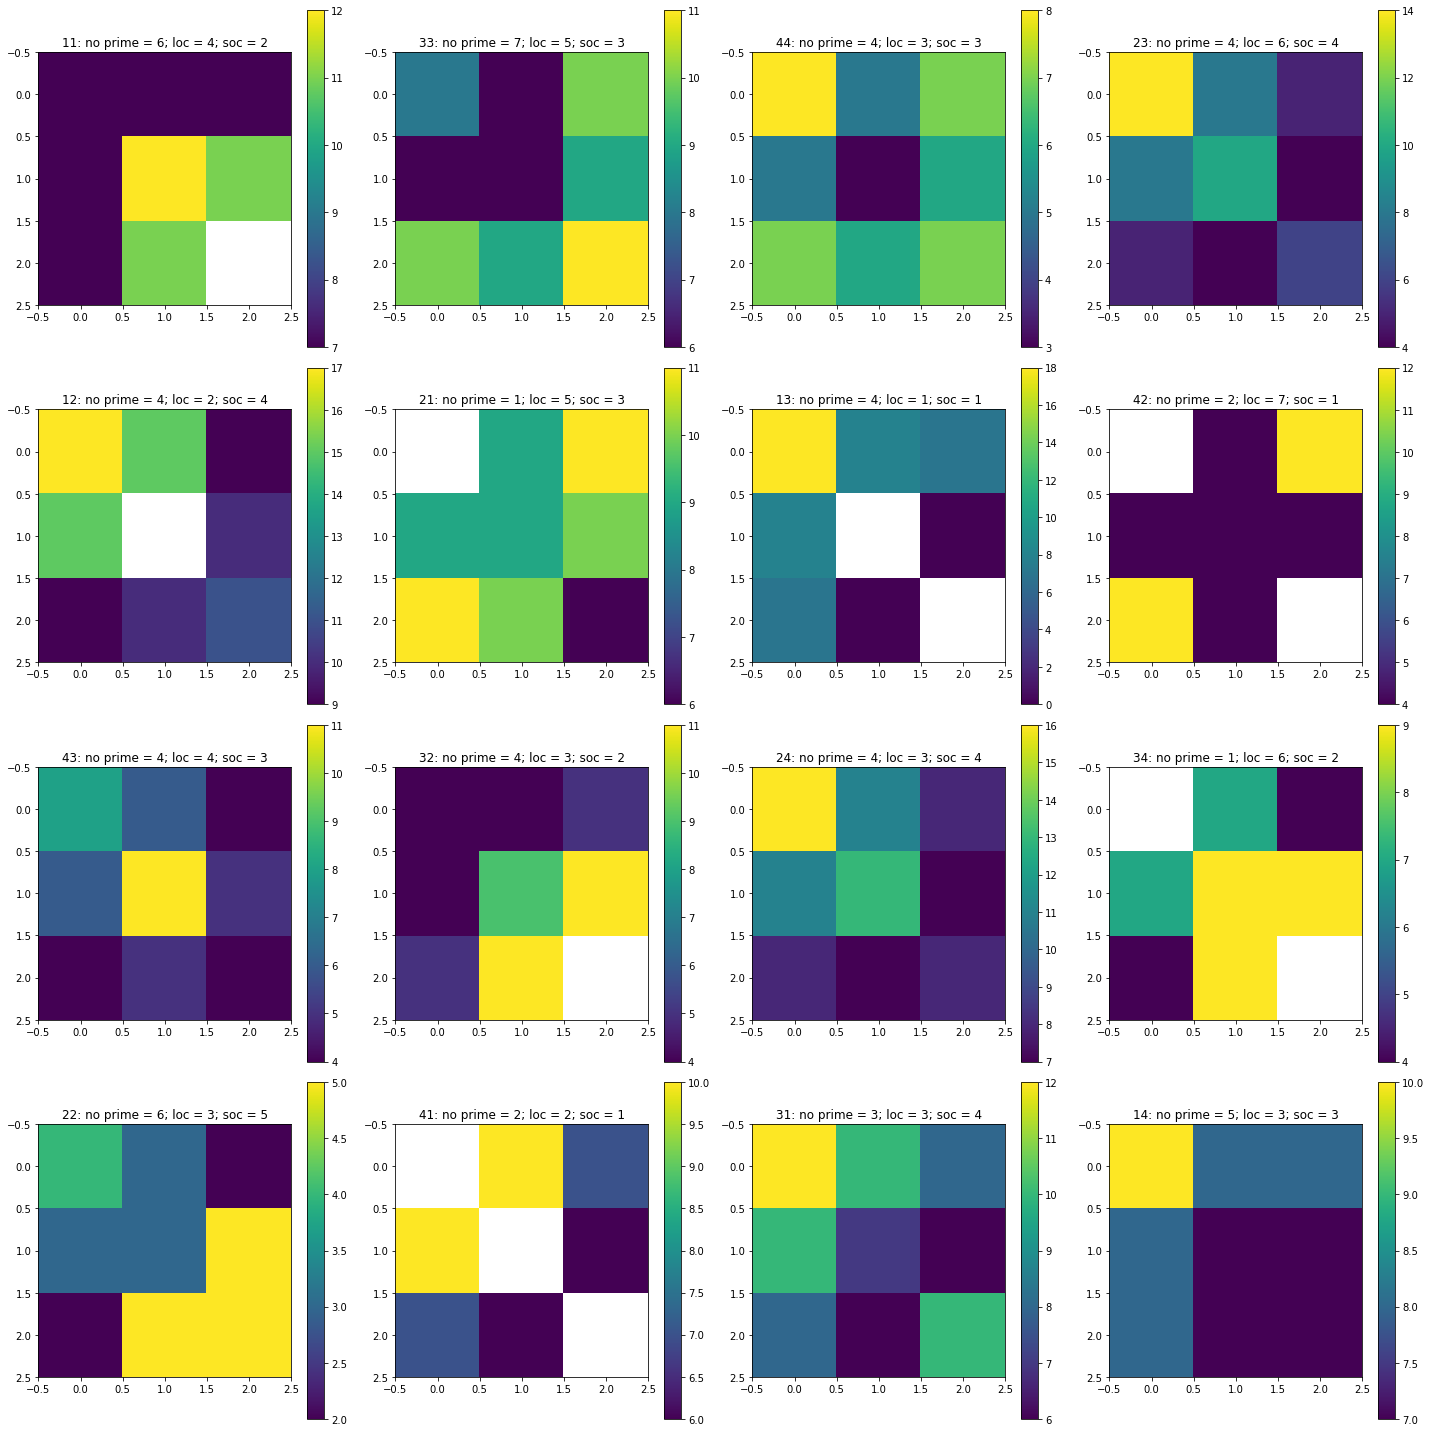

In [31]:
figure, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

i = 0
j = 0
for key in hzs:
    # Make the plot
    im = axes[j, i].imshow(hzs[key])
    
    #colorbar
    im.set_clim()
    figure.colorbar(im, ax=axes[j, i])
    
    #set title
    none_n = sums[key][1]
    loc_n = sums[key][2]
    soc_n = sums[key][3]
    axes[j, i].set_title(str(key) + ': no prime = ' + str(none_n) + '; loc = ' + str(loc_n) + '; soc = ' + str(soc_n))
    
    #changing i, j for next graph placement
    if i == 3:
        i = 0
        j += 1
    else:
        i += 1
    figure.tight_layout()

## C. Binning each comparison
### 1. Making the mask for each type of bin 

In [43]:
colored_arrays = {}

for key in all_keys:
    # Index keypresses for each story
    none = none_keys[key].T
    none_c = copy.deepcopy(none)
    none_c[none >= 0] = 3
    loc = loc_keys[key].T
    loc_c = copy.deepcopy(loc)
    loc_c[loc >= 0] = 5
    soc = soc_keys[key].T
    soc_c = copy.deepcopy(soc)
    soc_c[soc >= 0] = 7
    # Concatening keypresses
    final = np.concatenate((none_c,loc_c,soc_c), axis = 0)
    # Putting the final array in a dictionary
    colored_arrays[key] = final

mask = {}

for key in colored_arrays:
    x, y = colored_arrays[key].shape
    this_array = np.zeros((x, x))
    for i in range(0,x):
        for j in range(0, x):
            first = np.amax(colored_arrays[key][i])
            second = np.amax(colored_arrays[key][j])
            mult = first*second
            this_array[i,j] = mult
    # Putting filled in array in dict
    mask[key] = this_array

In [44]:
mask[14]

array([[ 9.,  9.,  9.,  9.,  9., 15., 15., 15., 21., 21., 21.],
       [ 9.,  9.,  9.,  9.,  9., 15., 15., 15., 21., 21., 21.],
       [ 9.,  9.,  9.,  9.,  9., 15., 15., 15., 21., 21., 21.],
       [ 9.,  9.,  9.,  9.,  9., 15., 15., 15., 21., 21., 21.],
       [ 9.,  9.,  9.,  9.,  9., 15., 15., 15., 21., 21., 21.],
       [15., 15., 15., 15., 15., 25., 25., 25., 35., 35., 35.],
       [15., 15., 15., 15., 15., 25., 25., 25., 35., 35., 35.],
       [15., 15., 15., 15., 15., 25., 25., 25., 35., 35., 35.],
       [21., 21., 21., 21., 21., 35., 35., 35., 49., 49., 49.],
       [21., 21., 21., 21., 21., 35., 35., 35., 49., 49., 49.],
       [21., 21., 21., 21., 21., 35., 35., 35., 49., 49., 49.]])

### 2. Binning

In [45]:
j_bins = {}

for key in jc_array:
    this_jbin = np.zeros((3,3))
    ######## NP - NP
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '9's
    this_mask[this_mask != 9] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '9's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[0,0] = val_sum/count
    ######## NP - loc
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '15's
    this_mask[this_mask != 15] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '15's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[0,1] = val_sum/count
        this_jbin[1,0] = val_sum/count
    ######## NP - soc
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '21's
    this_mask[this_mask != 21] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '21's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[0,2] = val_sum/count
        this_jbin[2,0] = val_sum/count
    ######## loc - loc
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '25's
    this_mask[this_mask != 25] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '25's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[1,1] = val_sum/count
        this_jbin[1,1] = val_sum/count
    ######## loc - soc
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '35's
    this_mask[this_mask != 35] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '35's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[1,2] = val_sum/count
        this_jbin[2,1] = val_sum/count
    ######## soc - soc
    # Making the Mask
    this_mask = np.copy(mask[key])
    # Zero out all but '49's
    this_mask[this_mask != 49] = 0
    # Zero out diagonal
    n = this_mask.shape[0]
    this_mask[range(n), range(n)] = 0
    # Zero out lower triangle
    this_mask = np.triu(this_mask, k = 0)
    # Turn '49's into '1's
    this_mask[this_mask > 0] = 1
    # Multiplying the mask by the Jaccard Index Array
    masked_array =  this_mask * jc_array[key]
    # Iterate through elements in array to add values and count how many there are
    count = 0
    val_sum = 0
    for x in masked_array:
        for y in x:
            if y > 0:
                val_sum += y
                count += 1
    # Putting the average masked value in this_jbin
    if count != 0:
        this_jbin[2,2] = val_sum/count
        this_jbin[2,2] = val_sum/count
    #######################################################################
    # Put this_jbin in j_bins dict
    j_bins[key] = this_jbin
    

## D. Plotting

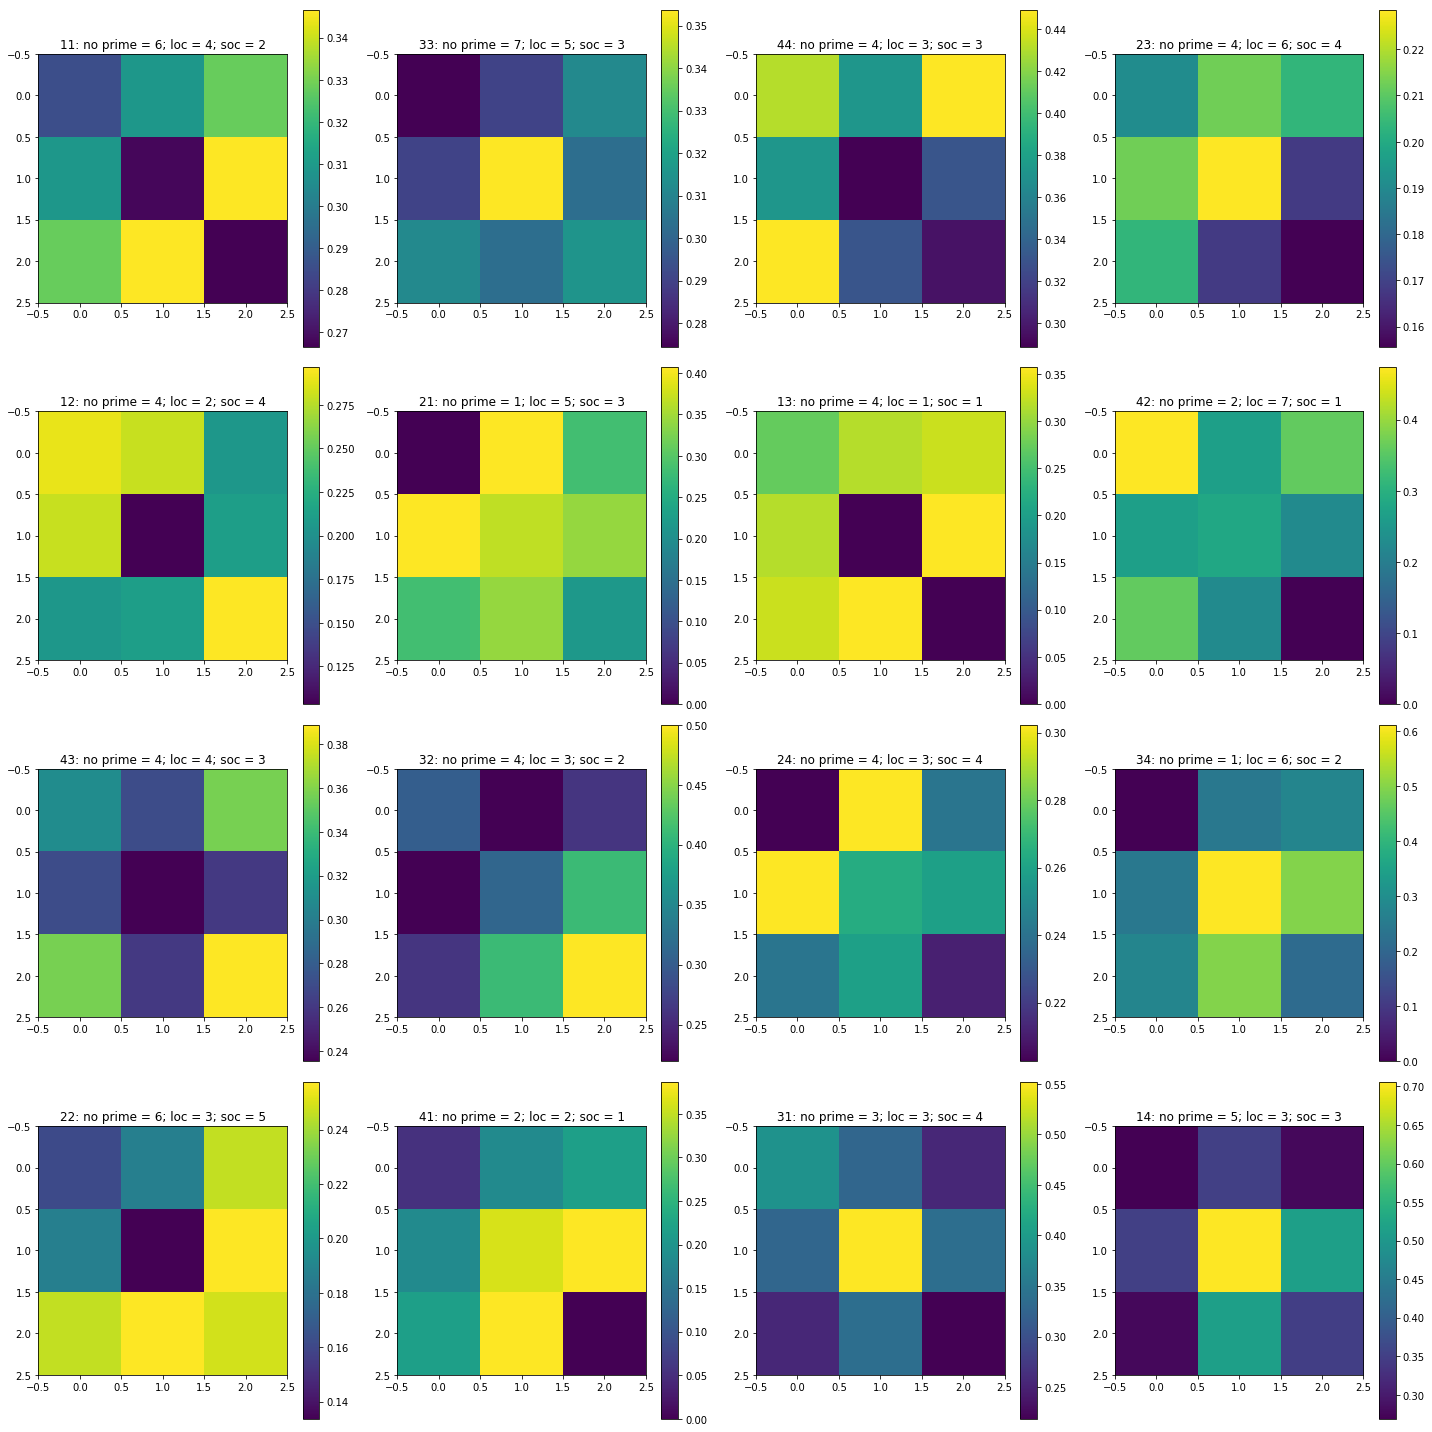

In [46]:
figure, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

i = 0
j = 0
for key in j_bins:
    # Make the plot
    im = axes[j, i].imshow(j_bins[key])
    
    #colorbar
    im.set_clim()
    figure.colorbar(im, ax=axes[j, i])
    
    #set title
    none_n = sums[key][1]
    loc_n = sums[key][2]
    soc_n = sums[key][3]
    axes[j, i].set_title(str(key) + ': no prime = ' + str(none_n) + '; loc = ' + str(loc_n) + '; soc = ' + str(soc_n))
    
    #changing i, j for next graph placement
    if i == 3:
        i = 0
        j += 1
    else:
        i += 1
    figure.tight_layout()

## E. Averaging across stories
### 1. Compute

In [47]:
# Concatenate Matrices along the third dimension
count = 0
for key in j_bins:
    # ONLY KEEP TEMPORARILY
    # Replace zeros with nans
    j_bins[key][j_bins[key] <= 0] = float('Nan')
    if count == 0:
        all_j_bins = j_bins[key]
        count =+ 1
    else:
        all_j_bins = np.dstack((all_j_bins, j_bins[key]))

# NanMean
avg_all_j_bins_actual = np.nanmean(all_j_bins, axis = 2)

### 2. Plot

[Text(0, 0, 'NP'), Text(0, 0, 'L'), Text(0, 0, 'S')]

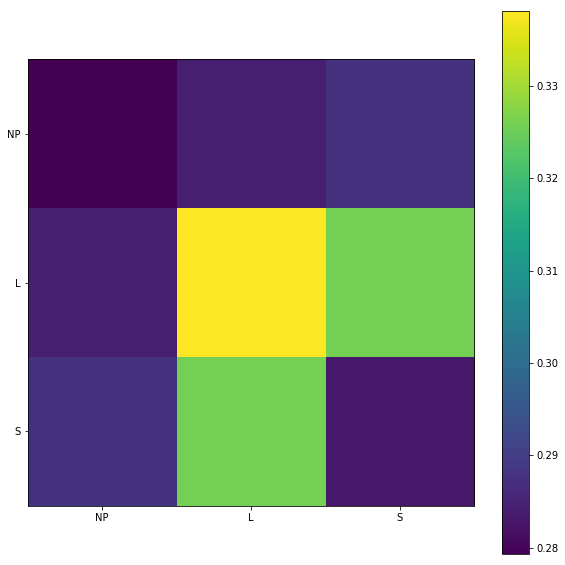

In [48]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(avg_all_j_bins_actual)

fig.colorbar(im)

# X ticks
x_label_list = ['NP', 'L', 'S']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

# Y ticks
y_label_list = ['NP', 'L', 'S']
ax.set_yticks([0,1,2])
ax.set_yticklabels(x_label_list)


# V. Permutation Testing
## A. Randomly assign people to be in mix_loc, mix_soc, mix_none 
## - compare all participants with jaccard analysis
## - mask data to bin the types of comparisons
## - average the types of comparisons
## - organize the types of comparisons in 3 x 3 matrix
## - append the resulting matrix into array with other permutations' matrices

In [55]:
N_perms = 1000
count_it = 0
sim_vals = []
for i in range(0, N_perms):
    ## Randomly assign the keypresses into categories preserving the number of participants in each category
    mix_loc = {}
    mix_soc = {}
    mix_none = {}
    for key in all_keys:
        # Permute an array the length of the number of columns
        this_order = np.random.permutation(all_keys[key].shape[1])
        # Shuffle the columns of the keys based on the permutation
        permuted_keys = all_keys[key][:, this_order]
        # Assign the participants to each group based on the number of actual participants are in that group
        mix_none[key] = permuted_keys[:, 0: sums[key][1]]
        mix_loc[key] = permuted_keys[:, sums[key][1]: (sums[key][1]+ sums[key][2])]
        mix_soc[key] = permuted_keys[:, (sums[key][1]+ sums[key][2]): sums[key][0]]
    
    ## Create participant by sentence array
    keypress_array = {}
    summary_vals = {}

    for key in all_keys:
        # No prime
        none = mix_none[key].T
        n_none, y = none.shape
        # Loc prime
        loc = mix_loc[key].T
        n_loc, y = none.shape
        # Soc prime
        soc = mix_soc[key].T
        n_soc, y = none.shape
        # Concatening keypresses
        final = np.concatenate((none,loc,soc), axis = 0)
        # Putting the final array in a dictionary
        keypress_array[key] = final
        # Putting summary vals together
        summary_vals[key] = np.array([n_none, n_loc, n_soc])
    
    ## Participant x participant matrix
    jc_array = {}

    for key in keypress_array:
        n, y  = keypress_array[key].shape
        this_array = np.zeros((n,n))
        for i in range(0, n):
            for j in range(0, n):
                this_score = jaccard_score(keypress_array[key][i], keypress_array[key][j])
                this_array[i,j] = this_score
        jc_array[key] = this_array
    
    ## Making the mask for each type of bin
    colored_arrays = {}

    for key in all_keys:
        # Index keypresses for each story
        # No prime
        none = mix_none[key].T
        none_c = copy.deepcopy(none)
        none_c[none >= 0] = 3
        # Loc prime
        loc = mix_loc[key].T
        loc_c = copy.deepcopy(loc)
        loc_c[loc >= 0] = 5
        # Soc prime
        soc = mix_soc[key].T
        soc_c = copy.deepcopy(soc)
        soc_c[soc >= 0] = 7
        # Concatening keypresses
        final = np.concatenate((none_c,loc_c,soc_c), axis = 0)
        # Putting the final array in a dictionary
        colored_arrays[key] = final

    mask = {}

    for key in colored_arrays:
        x, y = colored_arrays[key].shape
        this_array = np.zeros((x, x))
        for i in range(0,x):
            for j in range(0, x):
                first = np.amax(colored_arrays[key][i])
                second = np.amax(colored_arrays[key][j])
                mult = first*second
                this_array[i,j] = mult
        # Putting filled in array in dict
        mask[key] = this_array
    
    ## Binning
    j_bins = {}

    for key in jc_array:
        this_jbin = np.zeros((3,3))
        ######## NP - NP
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '9's
        this_mask[this_mask != 9] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '9's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[0,0] = val_sum/count
        ######## NP - loc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '15's
        this_mask[this_mask != 15] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '15's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[0,1] = val_sum/count
            this_jbin[1,0] = val_sum/count
        ######## NP - soc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '21's
        this_mask[this_mask != 21] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '21's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[0,2] = val_sum/count
            this_jbin[2,0] = val_sum/count
        ######## loc - loc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '25's
        this_mask[this_mask != 25] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '25's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[1,1] = val_sum/count
            this_jbin[1,1] = val_sum/count
        ######## loc - soc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '35's
        this_mask[this_mask != 35] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '35's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[1,2] = val_sum/count
            this_jbin[2,1] = val_sum/count
        ######## soc - soc
        # Making the Mask
        this_mask = np.copy(mask[key])
        # Zero out all but '49's
        this_mask[this_mask != 49] = 0
        # Zero out diagonal
        n = this_mask.shape[0]
        this_mask[range(n), range(n)] = 0
        # Zero out lower triangle
        this_mask = np.triu(this_mask, k = 0)
        # Turn '49's into '1's
        this_mask[this_mask > 0] = 1
        # Multiplying the mask by the Jaccard Index Array
        masked_array =  this_mask * jc_array[key]
        # Iterate through elements in array to add values and count how many there are
        count = 0
        val_sum = 0
        for x in masked_array:
            for y in x:
                if y > 0:
                    val_sum += y
                    count += 1
        # Putting the average masked value in this_jbin
        if count != 0:
            this_jbin[2,2] = val_sum/count
            this_jbin[2,2] = val_sum/count
        #######################################################################
        # Put this_jbin in j_bins dict
        j_bins[key] = this_jbin
        
    ## Avg across stories
    #Concatenate Matrices along the third dimension
    count = 0
    for key in j_bins:
        # ONLY KEEP TEMPORARILY
        # Replace zeros with nans
        j_bins[key][j_bins[key] <= 0] = float('Nan')
        if count == 0:
            all_j_bins = j_bins[key]
            count =+ 1
        else:
            all_j_bins = np.dstack((all_j_bins, j_bins[key]))

    # NanMean
    avg_all_j_bins = np.nanmean(all_j_bins, axis = 2)
    
    print(avg_all_j_bins)
    
    # Add avg_all_j_bins to others of other iterations
    if count_it == 0:
        all_perms = avg_all_j_bins
        count_it += 1
    else:
        all_perms = np.dstack((all_perms, avg_all_j_bins))
        
    # Calculate similarity values and append
    sim_vals.append(((avg_all_j_bins[1,1] + avg_all_j_bins[2,2])/2) - avg_all_j_bins[1,2])


[[0.29884664 0.28203796 0.28986196]
 [0.28203796 0.29334519 0.30203952]
 [0.28986196 0.30203952 0.33482482]]
[[0.2783112  0.30324755 0.27117153]
 [0.30324755 0.30163426 0.3141281 ]
 [0.27117153 0.3141281  0.3245446 ]]
[[0.27975087 0.28600315 0.28956029]
 [0.28600315 0.29588935 0.30197179]
 [0.28956029 0.30197179 0.32271229]]
[[0.28023825 0.29522862 0.30796315]
 [0.29522862 0.24872098 0.30016769]
 [0.30796315 0.30016769 0.30265308]]
[[0.26222202 0.30795984 0.28343162]
 [0.30795984 0.32663458 0.29832037]
 [0.28343162 0.29832037 0.28460368]]
[[0.26522723 0.26618993 0.2766191 ]
 [0.26618993 0.29566679 0.31954181]
 [0.2766191  0.31954181 0.36005079]]
[[0.28598035 0.30604563 0.31604156]
 [0.30604563 0.30057121 0.31215408]
 [0.31604156 0.31215408 0.33106163]]
[[0.31143485 0.31172011 0.27163307]
 [0.31172011 0.31522695 0.32104841]
 [0.27163307 0.32104841 0.27550831]]
[[0.31277629 0.28258977 0.27642472]
 [0.28258977 0.29865611 0.30026049]
 [0.27642472 0.30026049 0.28086678]]
[[0.26474642 0.3022

[[0.27813611 0.30299428 0.31223196]
 [0.30299428 0.29612464 0.2947323 ]
 [0.31223196 0.2947323  0.3369574 ]]
[[0.25923709 0.29003555 0.33307103]
 [0.29003555 0.25199946 0.30686761]
 [0.33307103 0.30686761 0.3652647 ]]
[[0.27626056 0.31610203 0.2983197 ]
 [0.31610203 0.29704525 0.27380275]
 [0.2983197  0.27380275 0.26253355]]
[[0.29939638 0.30076035 0.34401633]
 [0.30076035 0.26972446 0.29922074]
 [0.34401633 0.29922074 0.34756729]]
[[0.26568482 0.29100902 0.30687648]
 [0.29100902 0.30666284 0.32785742]
 [0.30687648 0.32785742 0.28631854]]
[[0.2662449  0.28249986 0.28757579]
 [0.28249986 0.31723289 0.30315875]
 [0.28757579 0.30315875 0.33598213]]
[[0.29622445 0.30179808 0.29594082]
 [0.30179808 0.27076847 0.30011697]
 [0.29594082 0.30011697 0.29983036]]
[[0.28139947 0.29969378 0.29275311]
 [0.29969378 0.30888013 0.29634158]
 [0.29275311 0.29634158 0.27251587]]
[[0.32827379 0.31829342 0.3027777 ]
 [0.31829342 0.25657202 0.27982625]
 [0.3027777  0.27982625 0.28703338]]
[[0.28204422 0.3032

[[0.26047141 0.27978425 0.32342878]
 [0.27978425 0.29646543 0.27348085]
 [0.32342878 0.27348085 0.33800664]]
[[0.26398016 0.30427396 0.28962235]
 [0.30427396 0.31969415 0.30900676]
 [0.28962235 0.30900676 0.34913123]]
[[0.30576571 0.30386727 0.30107607]
 [0.30386727 0.30143019 0.2837993 ]
 [0.30107607 0.2837993  0.26264687]]
[[0.27035445 0.30251772 0.3021208 ]
 [0.30251772 0.33176961 0.28563882]
 [0.3021208  0.28563882 0.3091507 ]]
[[0.28015209 0.29357802 0.26117812]
 [0.29357802 0.28785699 0.28650955]
 [0.26117812 0.28650955 0.35677465]]
[[0.24599066 0.28696006 0.27880698]
 [0.28696006 0.32712188 0.33462381]
 [0.27880698 0.33462381 0.33364729]]
[[0.29250739 0.31324532 0.28040003]
 [0.31324532 0.34778668 0.29869206]
 [0.28040003 0.29869206 0.25394975]]
[[0.282619   0.28518727 0.31974217]
 [0.28518727 0.26771831 0.28750715]
 [0.31974217 0.28750715 0.33696854]]
[[0.27068134 0.32627852 0.27847628]
 [0.32627852 0.34148108 0.28331498]
 [0.27847628 0.28331498 0.27634151]]
[[0.25232745 0.3031

[[0.28074156 0.32468714 0.27772906]
 [0.32468714 0.30652674 0.29593568]
 [0.27772906 0.29593568 0.32896136]]
[[0.27418003 0.3212772  0.28335548]
 [0.3212772  0.32375596 0.30072792]
 [0.28335548 0.30072792 0.28990135]]
[[0.29302211 0.30959461 0.28716197]
 [0.30959461 0.29396047 0.30008378]
 [0.28716197 0.30008378 0.30824825]]
[[0.26437815 0.29780552 0.29770273]
 [0.29780552 0.35709454 0.31145776]
 [0.29770273 0.31145776 0.2941395 ]]
[[0.33531407 0.29257884 0.28119587]
 [0.29257884 0.3237697  0.30426415]
 [0.28119587 0.30426415 0.23940858]]
[[0.284474   0.30027048 0.27711338]
 [0.30027048 0.32179492 0.31099423]
 [0.27711338 0.31099423 0.30030138]]
[[0.29381261 0.30020252 0.29397595]
 [0.30020252 0.31826282 0.28940815]
 [0.29397595 0.28940815 0.33238941]]
[[0.285385   0.29541653 0.28495621]
 [0.29541653 0.26878375 0.28424099]
 [0.28495621 0.28424099 0.33513789]]
[[0.30505145 0.30560514 0.30569331]
 [0.30560514 0.29942128 0.28886202]
 [0.30569331 0.28886202 0.28626143]]
[[0.26291629 0.2983

[[0.25213226 0.28300885 0.27878073]
 [0.28300885 0.2993511  0.32112324]
 [0.27878073 0.32112324 0.36075959]]
[[0.26092719 0.29736878 0.29664643]
 [0.29736878 0.3004984  0.29370081]
 [0.29664643 0.29370081 0.29008329]]
[[0.26668916 0.31484909 0.28945861]
 [0.31484909 0.2894347  0.31735434]
 [0.28945861 0.31735434 0.32754973]]
[[0.30881962 0.28894047 0.29995504]
 [0.28894047 0.27810364 0.30293278]
 [0.29995504 0.30293278 0.28386994]]
[[0.2884969  0.33658441 0.28212321]
 [0.33658441 0.30840663 0.27723859]
 [0.28212321 0.27723859 0.26460523]]
[[0.26532563 0.30907698 0.30341852]
 [0.30907698 0.3281739  0.29048879]
 [0.30341852 0.29048879 0.28675698]]
[[0.31466205 0.28123924 0.29609052]
 [0.28123924 0.27894241 0.30568956]
 [0.29609052 0.30568956 0.34007537]]
[[0.28607603 0.32467118 0.28704152]
 [0.32467118 0.33467972 0.28015068]
 [0.28704152 0.28015068 0.26142984]]
[[0.3059199  0.29772417 0.28375718]
 [0.29772417 0.30537418 0.29776778]
 [0.28375718 0.29776778 0.35446432]]
[[0.30590475 0.2745

[[0.2773566  0.30230037 0.32966521]
 [0.30230037 0.27534306 0.29398382]
 [0.32966521 0.29398382 0.28762183]]
[[0.33541656 0.28192408 0.30315566]
 [0.28192408 0.29974422 0.26529821]
 [0.30315566 0.26529821 0.31959097]]
[[0.27027426 0.2963815  0.30748087]
 [0.2963815  0.31473227 0.30914656]
 [0.30748087 0.30914656 0.27693156]]
[[0.30435799 0.30863634 0.31616748]
 [0.30863634 0.25811722 0.28946754]
 [0.31616748 0.28946754 0.29365973]]
[[0.28597503 0.32069018 0.28715377]
 [0.32069018 0.33191961 0.30349776]
 [0.28715377 0.30349776 0.2711653 ]]
[[0.2858876  0.30804463 0.31685134]
 [0.30804463 0.30707729 0.29616365]
 [0.31685134 0.29616365 0.27761979]]
[[0.25870743 0.32364821 0.28300114]
 [0.32364821 0.29239263 0.30307809]
 [0.28300114 0.30307809 0.29896544]]
[[0.27756198 0.31069337 0.28144124]
 [0.31069337 0.3708985  0.2921796 ]
 [0.28144124 0.2921796  0.28662658]]
[[0.26825054 0.29694938 0.31996233]
 [0.29694938 0.29549611 0.28684639]
 [0.31996233 0.28684639 0.30181167]]
[[0.31045813 0.2957

[[0.25771101 0.31645168 0.30874413]
 [0.31645168 0.30926848 0.30120723]
 [0.30874413 0.30120723 0.31380713]]
[[0.25481832 0.28558689 0.30231764]
 [0.28558689 0.31101159 0.31858241]
 [0.30231764 0.31858241 0.3542077 ]]
[[0.26991651 0.28401001 0.3130602 ]
 [0.28401001 0.26878248 0.31970801]
 [0.3130602  0.31970801 0.36456486]]
[[0.33205305 0.27803983 0.31019286]
 [0.27803983 0.25554538 0.26860439]
 [0.31019286 0.26860439 0.29472696]]
[[0.29556929 0.27857897 0.29875048]
 [0.27857897 0.30255897 0.30318758]
 [0.29875048 0.30318758 0.27128445]]
[[0.25656257 0.29133604 0.3047782 ]
 [0.29133604 0.34378573 0.31745577]
 [0.3047782  0.31745577 0.32682873]]
[[0.25893136 0.29105849 0.2759269 ]
 [0.29105849 0.31821117 0.35370984]
 [0.2759269  0.35370984 0.29550606]]
[[0.24764853 0.30994475 0.32092434]
 [0.30994475 0.30695618 0.292391  ]
 [0.32092434 0.292391   0.33155906]]
[[0.28312454 0.32487232 0.25600982]
 [0.32487232 0.31929842 0.29108005]
 [0.25600982 0.29108005 0.26819671]]
[[0.27875316 0.3133

[[0.26635256 0.26736451 0.2995532 ]
 [0.26736451 0.29340137 0.32327706]
 [0.2995532  0.32327706 0.33232968]]
[[0.26275765 0.32502092 0.29813528]
 [0.32502092 0.32268667 0.28408312]
 [0.29813528 0.28408312 0.29811519]]
[[0.31101939 0.30832503 0.32358549]
 [0.30832503 0.3026672  0.27720979]
 [0.32358549 0.27720979 0.27299388]]
[[0.25153079 0.29410653 0.29813664]
 [0.29410653 0.32436801 0.31529001]
 [0.29813664 0.31529001 0.27179792]]
[[0.30011862 0.31357714 0.26801732]
 [0.31357714 0.29131399 0.28746819]
 [0.26801732 0.28746819 0.31517165]]
[[0.32195607 0.29235546 0.28929331]
 [0.29235546 0.29442802 0.33096883]
 [0.28929331 0.33096883 0.30656167]]
[[0.23148107 0.27901371 0.31331178]
 [0.27901371 0.30024257 0.31675394]
 [0.31331178 0.31675394 0.39857414]]
[[0.28691624 0.29740036 0.30217154]
 [0.29740036 0.27801734 0.33680107]
 [0.30217154 0.33680107 0.32228893]]
[[0.3072064  0.27473459 0.29378651]
 [0.27473459 0.26704716 0.32017558]
 [0.29378651 0.32017558 0.32151013]]
[[0.27232354 0.3131

[[0.27185296 0.27371836 0.28711279]
 [0.27371836 0.29121499 0.3273303 ]
 [0.28711279 0.3273303  0.31353015]]
[[0.27894523 0.30157149 0.31688128]
 [0.30157149 0.28429789 0.2928332 ]
 [0.31688128 0.2928332  0.28967742]]
[[0.30297214 0.30088478 0.33368964]
 [0.30088478 0.28124933 0.30417332]
 [0.33368964 0.30417332 0.31907857]]
[[0.29251179 0.28794136 0.2867589 ]
 [0.28794136 0.30173505 0.32122343]
 [0.2867589  0.32122343 0.38322136]]
[[0.31717926 0.29930613 0.3263134 ]
 [0.29930613 0.27749352 0.29413137]
 [0.3263134  0.29413137 0.26722784]]
[[0.26135674 0.32731857 0.29621151]
 [0.32731857 0.33727007 0.3120077 ]
 [0.29621151 0.3120077  0.27070054]]
[[0.27043799 0.30887157 0.32191688]
 [0.30887157 0.25944539 0.29405089]
 [0.32191688 0.29405089 0.30833725]]
[[0.28187251 0.28219293 0.32595795]
 [0.28219293 0.26141048 0.29459443]
 [0.32595795 0.29459443 0.3174019 ]]
[[0.30966694 0.32067824 0.31076419]
 [0.32067824 0.29423388 0.28630697]
 [0.31076419 0.28630697 0.28081904]]
[[0.24141325 0.2750

[[0.26510635 0.28968986 0.29522057]
 [0.28968986 0.31799742 0.28660226]
 [0.29522057 0.28660226 0.29357278]]
[[0.26055339 0.29639124 0.29541594]
 [0.29639124 0.29966277 0.29093197]
 [0.29541594 0.29093197 0.32280681]]
[[0.29882469 0.30451765 0.29086265]
 [0.30451765 0.33175025 0.29663279]
 [0.29086265 0.29663279 0.26310629]]
[[0.27639276 0.30932586 0.30563853]
 [0.30932586 0.27995328 0.30933835]
 [0.30563853 0.30933835 0.32555214]]
[[0.27997968 0.2667261  0.28219952]
 [0.2667261  0.31930346 0.31523962]
 [0.28219952 0.31523962 0.33082988]]
[[0.29879087 0.31204378 0.25719112]
 [0.31204378 0.31291313 0.30819101]
 [0.25719112 0.30819101 0.28763819]]
[[0.28898064 0.2917933  0.3365343 ]
 [0.2917933  0.26390676 0.28065233]
 [0.3365343  0.28065233 0.3211451 ]]
[[0.27366656 0.29371165 0.30628197]
 [0.29371165 0.2794035  0.34048134]
 [0.30628197 0.34048134 0.35557387]]
[[0.27053993 0.3033856  0.32137918]
 [0.3033856  0.29368056 0.29008862]
 [0.32137918 0.29008862 0.27869165]]
[[0.29203309 0.3012

[[0.27567387 0.30981641 0.31620731]
 [0.30981641 0.29693559 0.29779706]
 [0.31620731 0.29779706 0.3135775 ]]
[[0.26705065 0.30269535 0.32450822]
 [0.30269535 0.29753289 0.29661536]
 [0.32450822 0.29661536 0.33139787]]
[[0.30596077 0.2866505  0.27036368]
 [0.2866505  0.30289449 0.29222384]
 [0.27036368 0.29222384 0.33037441]]
[[0.28257385 0.32270979 0.28499746]
 [0.32270979 0.31491152 0.29437223]
 [0.28499746 0.29437223 0.28619455]]
[[0.2698804  0.29265113 0.30950545]
 [0.29265113 0.2697349  0.29118881]
 [0.30950545 0.29118881 0.30999026]]
[[0.27845746 0.28934496 0.3113892 ]
 [0.28934496 0.2854511  0.30932935]
 [0.3113892  0.30932935 0.31764436]]
[[0.2692762  0.31382071 0.31178811]
 [0.31382071 0.27493877 0.3042249 ]
 [0.31178811 0.3042249  0.28532374]]
[[0.28292702 0.28803807 0.29994959]
 [0.28803807 0.24914456 0.31505829]
 [0.29994959 0.31505829 0.36189746]]
[[0.29475789 0.28985629 0.2949773 ]
 [0.28985629 0.32992783 0.27939459]
 [0.2949773  0.27939459 0.30898418]]
[[0.29982999 0.3114

[[0.25885012 0.30645392 0.28746419]
 [0.30645392 0.3365563  0.34777919]
 [0.28746419 0.34777919 0.25740334]]
[[0.31957421 0.28415938 0.30508202]
 [0.28415938 0.28901842 0.30080555]
 [0.30508202 0.30080555 0.26980021]]
[[0.27489454 0.29304697 0.31640271]
 [0.29304697 0.29257655 0.32291813]
 [0.31640271 0.32291813 0.29401055]]
[[0.26639973 0.28774303 0.299412  ]
 [0.28774303 0.25038501 0.30572559]
 [0.299412   0.30572559 0.33710618]]
[[0.29310018 0.29110057 0.31281371]
 [0.29110057 0.27787646 0.29987337]
 [0.31281371 0.29987337 0.32382515]]
[[0.29780688 0.28662254 0.32752707]
 [0.28662254 0.26885076 0.28846395]
 [0.32752707 0.28846395 0.34783568]]
[[0.273585   0.29953976 0.29868751]
 [0.29953976 0.28854241 0.3243839 ]
 [0.29868751 0.3243839  0.33747085]]
[[0.25233935 0.31522114 0.30352365]
 [0.31522114 0.29813936 0.28752752]
 [0.30352365 0.28752752 0.30960249]]
[[0.29855994 0.28369126 0.29408584]
 [0.28369126 0.26006183 0.28729962]
 [0.29408584 0.28729962 0.33660435]]
[[0.29154315 0.2858

[[0.28947338 0.30345161 0.29806082]
 [0.30345161 0.27835609 0.28982797]
 [0.29806082 0.28982797 0.26182149]]
[[0.27672128 0.29239015 0.28283535]
 [0.29239015 0.33377458 0.27888286]
 [0.28283535 0.27888286 0.32572063]]
[[0.29234684 0.29338258 0.29712649]
 [0.29338258 0.29790898 0.31085516]
 [0.29712649 0.31085516 0.30386283]]
[[0.27207608 0.29820557 0.27879391]
 [0.29820557 0.31507441 0.31237729]
 [0.27879391 0.31237729 0.28693754]]
[[0.29813319 0.31948565 0.28245895]
 [0.31948565 0.29672133 0.28278122]
 [0.28245895 0.28278122 0.26378212]]
[[0.30093279 0.29428821 0.29618196]
 [0.29428821 0.29839614 0.27602015]
 [0.29618196 0.27602015 0.33273644]]
[[0.27969055 0.28953263 0.29909263]
 [0.28953263 0.33681113 0.29990427]
 [0.29909263 0.29990427 0.31727198]]
[[0.30313319 0.29225854 0.28794232]
 [0.29225854 0.27340456 0.30963412]
 [0.28794232 0.30963412 0.33225068]]
[[0.27718751 0.29814545 0.31820127]
 [0.29814545 0.27435052 0.29105977]
 [0.31820127 0.29105977 0.31142962]]
[[0.28574669 0.2991

[[0.26979304 0.31132561 0.27681146]
 [0.31132561 0.32073352 0.30487818]
 [0.27681146 0.30487818 0.28547537]]
[[0.28906012 0.33271264 0.27778373]
 [0.33271264 0.29903931 0.28287054]
 [0.27778373 0.28287054 0.31363042]]
[[0.28190471 0.29607498 0.31789242]
 [0.29607498 0.29692423 0.28365324]
 [0.31789242 0.28365324 0.28249891]]
[[0.28330834 0.31592365 0.30363414]
 [0.31592365 0.28390299 0.28719204]
 [0.30363414 0.28719204 0.2622309 ]]
[[0.29041923 0.29388125 0.29966364]
 [0.29388125 0.29399536 0.31711121]
 [0.29966364 0.31711121 0.33249466]]
[[0.29938159 0.30397863 0.2794457 ]
 [0.30397863 0.32475435 0.31725339]
 [0.2794457  0.31725339 0.27059832]]
[[0.29489673 0.2624033  0.29883299]
 [0.2624033  0.28840977 0.31330776]
 [0.29883299 0.31330776 0.37347973]]
[[0.26807181 0.3083427  0.29941882]
 [0.3083427  0.33199241 0.30373455]
 [0.29941882 0.30373455 0.27028873]]
[[0.25357905 0.30114261 0.32401814]
 [0.30114261 0.26520867 0.29334267]
 [0.32401814 0.29334267 0.36437608]]
[[0.27650908 0.2797

## B. Avg matrices and plot

[Text(0, 0, 'NP'), Text(0, 0, 'L'), Text(0, 0, 'S')]

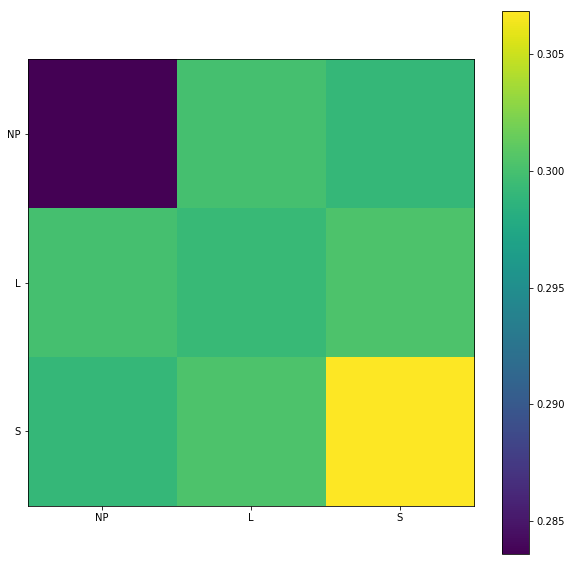

In [56]:
avg_perm = np.mean(all_perms, axis = 2)

fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(avg_perm)

fig.colorbar(im)

# X ticks
x_label_list = ['NP', 'L', 'S']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

# Y ticks
y_label_list = ['NP', 'L', 'S']
ax.set_yticks([0,1,2])
ax.set_yticklabels(x_label_list)

## C. Calculate p-value for each box and plot matrix of p-values

[Text(0, 0, 'NP'), Text(0, 0, 'L'), Text(0, 0, 'S')]

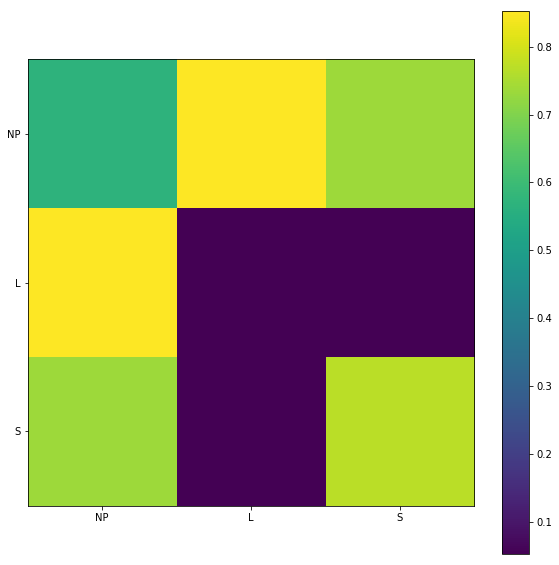

In [57]:
p_vals = np.zeros((3,3))

for i in range(0,3):
    for j in range(0, 3):
        these_vals = all_perms[i, j, :]
        p_vals[i,j] = ((these_vals > avg_all_j_bins_actual[i,j]).sum())/N_perms

# Plot
fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(p_vals)

fig.colorbar(im)

# X ticks
x_label_list = ['NP', 'L', 'S']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

# Y ticks
y_label_list = ['NP', 'L', 'S']
ax.set_yticks([0,1,2])
ax.set_yticklabels(x_label_list)

## D. Similarity of keypresses within a priming group
### 1. Calculate the actual similarity value

In [58]:
actual_sim_val = ((avg_all_j_bins_actual[1,1] + avg_all_j_bins_actual[2,2])/2) - avg_all_j_bins_actual[1,2]

### 2. Find the p-value this value

The p value is  0.831


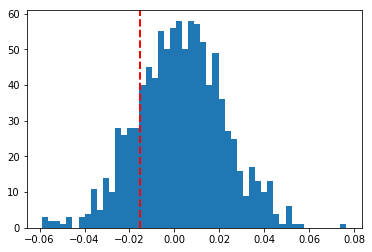

In [59]:
# convert list of PEs to np
sims = np.asarray(sim_vals)
# Plot the histogram
plt.hist(sims, bins = 50)
# Show the actual data
plt.axvline(x=actual_sim_val, color='r', linestyle='dashed', linewidth=2)
# Calculate the P-value
p_val = ((sims > actual_sim_val).sum())/1000
print('The p value is ', p_val)

In [61]:
avg_all_j_bins_actual

array([[0.27930343, 0.28417848, 0.28787559],
       [0.28417848, 0.33811263, 0.32587493],
       [0.28787559, 0.32587493, 0.28320346]])